### Setup/Cleaning Data

In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import urllib2
import scipy.stats as stats

np.set_printoptions(precision=3, suppress=True)
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)

# chopping data based on thresholds on x and y coordinates
x_bounds = (409, 3529)
y_bounds = (1564, 3124)

def check_in_bounds(row, x_bounds, y_bounds):
    if row[0] < x_bounds[0] or row[0] > x_bounds[1]:
        return False
    if row[1] < y_bounds[0] or row[1] > y_bounds[1]:
        return False
    if row[3] == 0:
        return False
    
    return True

indices_in_bound, = np.where(np.apply_along_axis(check_in_bounds, 1, csv, x_bounds, y_bounds))
data_thresholded = csv[indices_in_bound]
n = data_thresholded.shape[0]

### 1) What is the average synapse density per voxel? How does it compare to average and min/max synapse density per bin?

avg density per voxel:  0.0012107238853
average per bin:  0.00115002980202 , std dev:  0.000406563246763
max/min bin density:  0.00338020281217 ,  0.0
41.4424739456


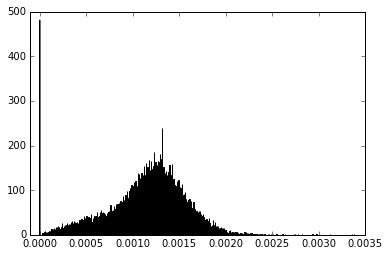

In [2]:
total_unmasked = np.sum(data_thresholded[:, 3])
total_syn = np.sum(data_thresholded[:, 4])
print "avg density per voxel: ", total_syn/total_unmasked
a = np.apply_along_axis(lambda x:x[4]/x[3], 1, data_thresholded)
print "average per bin: ", np.average(a), ", std dev: ", np.std(a)
print "max/min bin density: ", np.max(a), ", ", np.min(a)
print np.sum(a)
hist_n, bins, _ = plt.hist(a, 1000)
plt.xlim(-.0001, .0035)
plt.show()

Note the 2 large spikes in the histogram.

#### 1.1) What fraction of the samples have 0 density? How much data was thrown out due to unmasked being 0?

In [3]:
print "fraction: ", hist_n[0]/len(a)

ux = np.unique(data_thresholded[:, 0]).shape[0]
uy = np.unique(data_thresholded[:, 1]).shape[0]
uz = np.unique(data_thresholded[:, 2]).shape[0]
exp = ux*uy*uz
actual = data_thresholded.shape[0]
print "actual: %d, expected: %d, difference: %d" % (actual, exp, exp-actual)

fraction:  0.0133477633478
actual: 36036, expected: 36531, difference: 495


### 2) Is joint distribution uniform?

In [4]:
# chi squared test on all bins

def synapses_over_unmasked(row):
    s = (row[4]/row[3])*(64**3)
    return [row[0], row[1], row[2], s]

syn_unmasked = np.apply_along_axis(synapses_over_unmasked, 1, data_thresholded)
# divide synapses/unmasked by std_dev
# syn_normalized = np.apply_along_axis(normalize_syn, 1, syn_unmasked, 
#                                     np.mean(syn_unmasked[:,-1]), np.std(syn_unmasked[:,-1]))
syn_normalized = syn_unmasked
sum_syn_norm = np.sum(syn_normalized[:, 3])
avg_syn_norm = (sum_syn_norm/n)*np.ones((n))
syn_norm_1col = syn_normalized[:, -1]
print avg_syn_norm
print syn_norm_1col
print stats.chisquare(syn_norm_1col, avg_syn_norm)

[ 301.473  301.473  301.473 ...,  301.473  301.473  301.473]
[ 400.358  420.178  425.628 ...,  242.403  157.405  246.08 ]
Power_divergenceResult(statistic=1357761.9606434423, pvalue=0.0)


Conclude that the joint distribution is not uniform.    

### 3) Are the marginal distributions uniform?

In [5]:
def marginalize_along_axis(axis):
    unique = np.unique(syn_normalized[:, axis])
    idx_dict = dict(zip(unique, range(len(unique))))
    syn_per_unique = np.zeros(len(unique))
    for row in syn_normalized[:,]:
        syn_per_unique[idx_dict[row[axis]]] += row[-1]
    return syn_per_unique

for axis in range(3):
    marginalized_data = marginalize_along_axis(axis)
    n = len(np.unique(syn_normalized[:, axis]))
    print "n=", n
    avg = sum_syn_norm/n
    avg_vec = np.ones((n))*avg
    print "axis = ", axis, "chisquare test: ", stats.chisquare(marginalized_data, avg_vec)

n= 81
axis =  0 chisquare test:  Power_divergenceResult(statistic=19641.411877476548, pvalue=0.0)
n= 41
axis =  1 chisquare test:  Power_divergenceResult(statistic=340888.29730870121, pvalue=0.0)
n= 11
axis =  2 chisquare test:  Power_divergenceResult(statistic=89131.566812296718, pvalue=0.0)


Conclude that none of the marginals are uniform. 

### 4) Regression: predicting synapses/unmasked conditioned on x, y, z

In [6]:
# load our regressions
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
np.random.seed(1)
names = ['Linear Regression','SVR','KNN Regression','Random Forest Regression','Polynomial Regression']
regressions = [LinearRegression(),
               LinearSVR(C=1.0),
               KNN(n_neighbors=10, algorithm='auto'),
               RF(max_depth=5, max_features=1),
               Pipeline([('poly', PF(degree=2)),('linear', LinearRegression(fit_intercept=False))])]
k_fold = 10

def normalize_syn(row, pos, scale):
    row[-1] -= pos
    row[-1] *= 1.0/scale
    return row

"""
syn_normalized = np.apply_along_axis(normalize_syn, 1, syn_unmasked, 
                                     np.mean(syn_unmasked[:,-1]), np.std(syn_unmasked[:,-1]))
syn_normalized = np.apply_along_axis(normalize_syn, 1, syn_unmasked, 
                                     np.min(syn_unmasked[:,-1]), 
                                     np.max(syn_unmasked[:,-1])-np.min(syn_unmasked[:,-1]))
"""
syn_normalized = syn_unmasked

X = syn_normalized[:, [0, 1, 2]]
Y = syn_normalized[:, -1]
for name, reg in zip(names, regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (name, scores.mean(), scores.std() * 2))

R^2 of Linear Regression: 0.12 (+/- 0.16)
R^2 of SVR: -2.30 (+/- 6.29)
R^2 of KNN Regression: 0.20 (+/- 0.08)
R^2 of Random Forest Regression: 0.22 (+/- 0.11)
R^2 of Polynomial Regression: 0.18 (+/- 0.17)


Overall, regressions not successful.

#### 4.1) Marginal regressions

In [7]:
for i in xrange(3):
    X = syn_normalized[:, i].reshape(-1, 1)
    Y = syn_normalized[:, -1]
    print i
    for name, reg in zip(names, regressions):
        scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
        print("R^2 of %s: %0.2f (+/- %0.2f)" % (name, scores.mean(), scores.std() * 2))
    print

0
R^2 of Linear Regression: -0.01 (+/- 0.04)
R^2 of SVR: -2.77 (+/- 7.52)
R^2 of KNN Regression: -0.17 (+/- 0.36)
R^2 of Random Forest Regression: -0.07 (+/- 0.18)
R^2 of Polynomial Regression: -0.01 (+/- 0.02)

1
R^2 of Linear Regression: 0.12 (+/- 0.15)
R^2 of SVR: -2.07 (+/- 3.99)
R^2 of KNN Regression: 0.00 (+/- 0.19)
R^2 of Random Forest Regression: 0.14 (+/- 0.16)
R^2 of Polynomial Regression: 0.14 (+/- 0.16)

2
R^2 of Linear Regression: -0.01 (+/- 0.04)
R^2 of SVR: -0.85 (+/- 2.32)
R^2 of KNN Regression: -0.08 (+/- 0.08)
R^2 of Random Forest Regression: 0.04 (+/- 0.05)
R^2 of Polynomial Regression: 0.01 (+/- 0.05)



### 5) What is the optimal number of clusters on the 'cleaned' data?

[ 2100389.837  2094880.867  2089231.581  2082509.026  2082863.312
  2080530.204  2079116.938  2074708.757  2071551.705  2070263.031
  2067869.343  2067598.045  2068226.908  2067235.633]


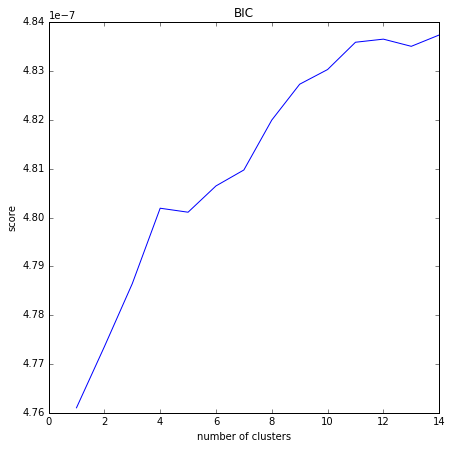

In [8]:
import sklearn.mixture as mixture

max_clusters = 15
bic = np.array([])
i = np.array(range(1, max_clusters))
for idx in range(1, max_clusters):
    gmm = mixture.GMM(n_components=idx, n_iter=1000, covariance_type='diag', random_state=1)
    gmm.fit(syn_normalized)
    bic = np.append(bic, gmm.bic(syn_normalized))
print bic
plt.figure(figsize=(7,7))
plt.plot(i, 1.0/bic)
plt.title('BIC')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.show()

Observe local maximums at 4 clusters and 12 clusters.

### 6) Compute mean, covariance on each cluster seperately

In [9]:
# to keep model as simple as possible, let's assume 4 clusters

n_clusters = 4
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag', random_state=1)
clusters = [[] for i in xrange(n_clusters)]
predicted = gmm.fit_predict(syn_normalized)
for label, row in zip(predicted, syn_normalized[:,]):
    clusters[label].append(row)

for i in xrange(n_clusters):
    clusters[i] = np.array(clusters[i])
    print "# of samples in cluster %d: %d" % (i+1, len(clusters[i])) 
    print "centroid: ", np.average(clusters[i], axis=0)
    print "cluster covariance: "
    covar = np.cov(clusters[i].T)
    print covar
    print "determinant of covariance matrix: ", np.linalg.det(covar)
    print

# of samples in cluster 1: 10413
centroid:  [ 2847.985  2298.506   612.963   315.191]
cluster covariance: 
[[ 168166.06     -365.784   -1288.3      6747.015]
 [   -365.784   98859.339   -1944.851    3117.071]
 [  -1288.3     -1944.851  121449.865    -613.809]
 [   6747.015    3117.071    -613.809   10118.623]]
determinant of covariance matrix:  1.96712741238e+19

# of samples in cluster 2: 6885
centroid:  [ 1885.862  1734.592   594.458   382.929]
cluster covariance: 
[[ 766013.849   -7179.378    7680.772    2402.616]
 [  -7179.378   12768.578   -1305.694     -99.946]
 [   7680.772   -1305.694  118941.368   -1899.735]
 [   2402.616     -99.946   -1899.735    3738.72 ]]
determinant of covariance matrix:  4.27383286219e+18

# of samples in cluster 3: 11317
centroid:  [ 1214.271  2324.484   619.122   295.86 ]
cluster covariance: 
[[ 233306.223   -2110.473   -2683.86    -2622.013]
 [  -2110.473   84653.307   -1514.014    3398.717]
 [  -2683.86    -1514.014  123618.931     541.291]
 [  -2622

Observations:
- 2 larger clusters of approximately equal size, and 2 smaller clusters of approximately equal size
- determinant of covariance matrix correlates with number of samples in cluster 
- note on-diagonal covariances are generally higher
- fairly large deviation between the average synapses across clusters

In [10]:
# compare diagonal covariances computed to whats returned by the GMM

print gmm.covars_

[[ 203310.188  127018.252  121675.619   10128.329]
 [ 774667.935   19529.065  118303.279    4585.876]
 [ 273742.095  114696.689  124027.93     8306.951]
 [ 781922.198   17627.35   126023.265   11754.486]]


### 7) Graph clusters in Euclidean 3D Space

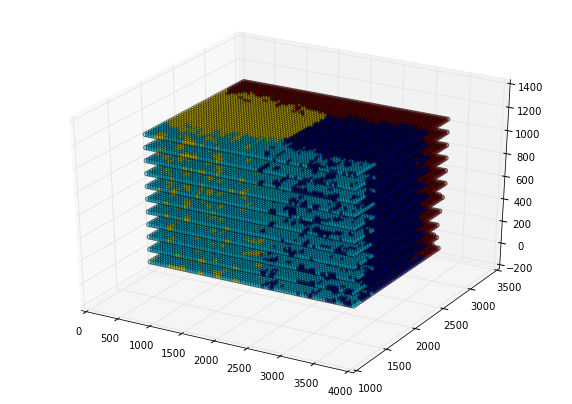

In [11]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.view_init()
ax.dist = 10  # distance

ax.scatter(
           syn_normalized[:, 0], syn_normalized[:, 1], syn_normalized[:, 2],  # data
           c=predicted,  # marker colour
           alpha=.5
    )

plt.show()

#TODO: graph the centroids and diagonal covariances as ellipsoids

### 8) PCA

[[ 0.11  -0.7    0.004  0.706]
 [-0.576 -0.13  -0.806 -0.035]
 [ 0.807  0.066 -0.584 -0.056]
 [-0.074  0.699 -0.091  0.705]]
[ 0.347  0.252  0.248  0.153]
(36036, 4)


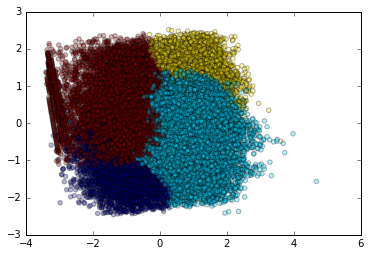

In [12]:
from sklearn.decomposition import PCA

# center each variable and give it unit variance for PCA

def center(row, means, std_devs):
    for idx, mean, std_dev in zip(range(4), means, std_devs):
        row[idx] -= mean
        row[idx] *= 1.0/std_dev
    return row

syn_centered = np.apply_along_axis(center, 1, syn_normalized,
                                   *zip(*[(np.average(syn_normalized[:, i]), 
                                   np.std(syn_normalized[:, i])) for i in range(4)]))
pca = PCA(n_components = 4)
transform = pca.fit_transform(syn_centered)
print pca.components_
print pca.explained_variance_ratio_
print transform.shape

# plot the clusters along the first 2 principal components
n_clusters = 4
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag', random_state=1)
predicted = gmm.fit_predict(syn_normalized)

plt.scatter(transform[:, 0], transform[:, 1], c=predicted, alpha=.3)
plt.show()

Observe fairly well defined boundary between clusters. Lets plot the 2D PCA when there are 12 clusters.

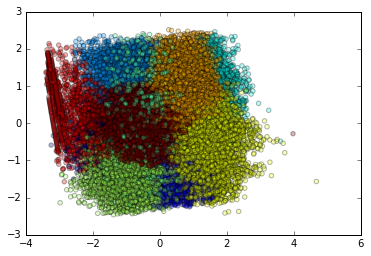

In [13]:
n_clusters = 12
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag', random_state=1)
predicted = gmm.fit_predict(syn_normalized)

plt.scatter(transform[:, 0], transform[:, 1], c=predicted, alpha=.3)
plt.show()

For larger clusters, boundaries remain pretty well defined, although they are not very apparent for small clusters.